#### Essayer d'apprendre les paramètres du ressort à partir des descripteurs des signaux pour avoir des coefs d'importance pour les descripteurs (poids à mettre pour le calcul des distance)

**Plan du notebook:**

**1.** Coefficients de corrélation

**2.** Régression linéaire pour apprendre les paramètres `F` et/ou `k` (ou SVM linéaire)

**3.** Analyse en composante principales

**4.** Autres méthodes de machine learning (SVM, tree) qui ont un paramètre `coef_` ou `feature_importance_`. Ce paramètre n'est pas simplement interprétable mais permet d'avoir une idée de l'importance relative des descripteurs si 2. donne de trop mauvais résultats

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

import simu_ressort
import descriptor

In [10]:
names_desc = ['mean', 'std', 'fr_max', 'ampl_max', 'spectral centroid',
              'spectral width', 'spectral platitude', 'spectral asymetry', 'autocor']

In [3]:
all_simus = simu_ressort.load_obj("./data/ressort/simus.pkl")

print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['N']))
print("The duration of each simu is {} dt.".format(np.shape(all_simus[0]['simu'])[1]))

print("{} descripteurs pour chaque simu".format(len(descriptor.compute_descriptor([1, 2]))))

81 parameters tested, and 200 simus for each parameter.
The duration of each simu is 1000 dt.
9 descripteurs pour chaque simu


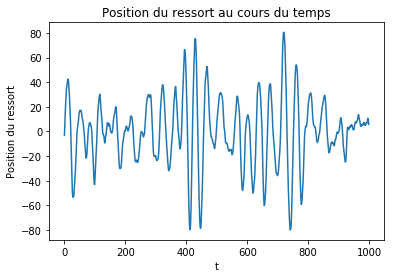

Descripteurs: [  2.02968818e-01   2.75933904e+01   2.40000000e-02   7.62580707e+03
  -1.43882735e-05   8.28794578e-02   1.49236472e+01  -5.79759825e-03
   1.00000000e+00]


In [4]:
i = 20
V = all_simus[25]['simu'][i, :]
simu_ressort.plot_ressort(V)
desc = descriptor.compute_descriptor(V)
print("Descripteurs:", desc)

### Preprocess data

In [5]:
nb_desc = len(descriptor.compute_descriptor([0]))
nb_simus = len(all_simus) * len(all_simus[0]['simu'])
print("{} descriptors and {} signals".format(nb_desc, nb_simus))

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)
D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:41: RuntimeWarning: invalid value encountered in true_divide
  autocorr = np.correlate(y, y)/norm


9 descriptors and 16200 signals


In [6]:
def preprocess_simu_to_numpy(all_simus):

    X_data = []
    Y_data = []

    for i in range(len(all_simus)):
        for j in range(len(all_simus[i]['simu'])):
            X_data.append(descriptor.compute_descriptor(all_simus[i]['simu'][j, :]))
            Y_data.append([all_simus[i]['F'], all_simus[i]['k']])
            
    return np.array(X_data), np.array(Y_data)

In [7]:
def separate_test_train(X_data, Y_data, pct_train=0.8):
    n_train = int(pct_train * len(X_data))
    
    X_train = X_data[:n_train, :]
    X_test = X_data[n_train:, :]    
    Y_train = Y_data[:n_train, :]    
    Y_test = Y_data[n_train:, :]
    
    return X_train, X_test, Y_train, Y_test

In [8]:
X_data, Y_data = preprocess_simu_to_numpy(all_simus)

# Mettre les variables à la même échelle
X_data = StandardScaler().fit_transform(X_data)

print("Shape of X_data: {} and Y_data: {}".format(np.shape(X_data), np.shape(Y_data)))

X_train, X_test, Y_train, Y_test = separate_test_train(X_data, Y_data, pct_train=0.8)

Shape of X_data: (16200, 9) and Y_data: (16200, 2)


In [11]:
# Transformer en DataFrame juste pour faire plus beau pour les coef de corr

X_df = pd.DataFrame(X_data)
X_df.columns = names_desc

# Ajouter les variables F et k
X_df['F'] = Y_data[:, 0]
X_df['k'] = Y_data[:, 1]

X_df.describe()

,mean,std,fr_max,ampl_max,spectral centroid,spectral width,spectral platitude,spectral asymetry,autocor,F,k
count,1.620000e+04,1.620000e+04,1.620000e+04,1.620000e+04,1.620000e+04,1.620000e+04,1.620000e+04,1.620000e+04,16200.000000,16200.000000,16200.000000
mean,4.187697e-18,-4.779167e-16,2.766210e-15,5.281125e-15,-3.894375e-15,1.603964e-14,-2.964693e-15,1.276615e-14,0.092237,0.500000,0.500000
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,0.995768,0.258207,0.258207
min,-7.895491e+00,-1.092833e+00,-2.405975e+00,-9.807896e-01,-4.697435e+00,-3.239788e+00,-1.482235e+00,-6.833238e+00,-3.446910,0.100000,0.100000
25%,-3.560981e-01,-6.535014e-01,-9.624921e-02,-6.331050e-01,-6.603398e-01,-6.591371e-01,-6.423849e-01,-5.235521e-01,0.000000,0.300000,0.300000
50%,6.150046e-03,-3.082756e-01,4.208536e-01,-3.295446e-01,1.537385e-01,-1.261588e-02,-2.511578e-01,8.885393e-02,0.000000,0.500000,0.500000
75%,3.685172e-01,3.048089e-01,7.655887e-01,2.748946e-01,8.242021e-01,6.184025e-01,3.521751e-01,6.912784e-01,0.000000,0.700000,0.700000
max,8.048937e+00,9.980354e+00,1.213744e+00,1.002237e+01,1.438393e+00,3.130843e+00,7.904057e+00,1.641010e+00,3.446910,0.900000,0.900000


## 1. Coefficients de corrélation

In [12]:
X_df.corr()

,mean,std,fr_max,ampl_max,spectral centroid,spectral width,spectral platitude,spectral asymetry,autocor,F,k
mean,1.000000,-0.006481,0.007339,-0.007023,0.012579,-0.007294,0.005712,0.017487,0.004656,1.320954e-02,8.290246e-03
std,-0.006481,1.000000,-0.017791,0.976521,-0.152783,-0.034011,0.223906,-0.164429,0.004967,-5.812865e-01,-4.723082e-01
fr_max,0.007339,-0.017791,1.000000,0.015294,-0.015431,0.075320,-0.103348,0.051722,0.019200,-8.256606e-02,1.999590e-01
ampl_max,-0.007023,0.976521,0.015294,1.000000,-0.164636,0.013945,0.151014,-0.135003,0.007282,-6.121231e-01,-3.635294e-01
spectral centroid,0.012579,-0.152783,-0.015431,-0.164636,1.000000,-0.665859,0.514479,0.534812,-0.006301,1.918547e-01,-6.153038e-02
spectral width,-0.007294,-0.034011,0.075320,0.013945,-0.665859,1.000000,-0.891880,0.168661,0.005671,-7.485650e-02,3.696786e-01
spectral platitude,0.005712,0.223906,-0.103348,0.151014,0.514479,-0.891880,1.000000,-0.207623,-0.005375,2.646507e-02,-5.439912e-01
spectral asymetry,0.017487,-0.164429,0.051722,-0.135003,0.534812,0.168661,-0.207623,1.000000,-0.006800,9.875818e-02,2.436808e-01
autocor,0.004656,0.004967,0.019200,0.007282,-0.006301,0.005671,-0.005375,-0.006800,1.000000,-1.140007e-02,1.009661e-02
F,0.013210,-0.581286,-0.082566,-0.612123,0.191855,-0.074857,0.026465,0.098758,-0.011400,1.000000e+00,-1.320960e-15


In [13]:
X_df.corr()[['F', 'k']]

,F,k
mean,1.320954e-02,8.290246e-03
std,-5.812865e-01,-4.723082e-01
fr_max,-8.256606e-02,1.999590e-01
ampl_max,-6.121231e-01,-3.635294e-01
spectral centroid,1.918547e-01,-6.153038e-02
spectral width,-7.485650e-02,3.696786e-01
spectral platitude,2.646507e-02,-5.439912e-01
spectral asymetry,9.875818e-02,2.436808e-01
autocor,-1.140007e-02,1.009661e-02
F,1.000000e+00,-1.320960e-15


`F` et `k` fortement corrélés à `spectrak width`mais également à `spectral platitude` et `spectral centroid`

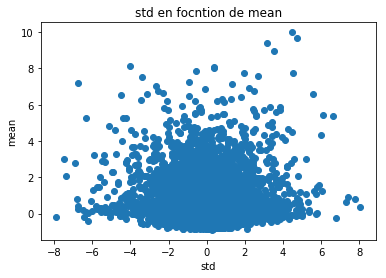

In [21]:
plt.scatter(X_data[:7000, 0], X_data[:7000, 1])
plt.title('std en focntion de mean')
plt.xlabel('std')
plt.ylabel('mean')
plt.show()

In [18]:
names_desc

['mean',
 'std',
 'fr_max',
 'ampl_max',
 'spectral centroid',
 'spectral width',
 'spectral platitude',
 'spectral asymetry',
 'autocor']

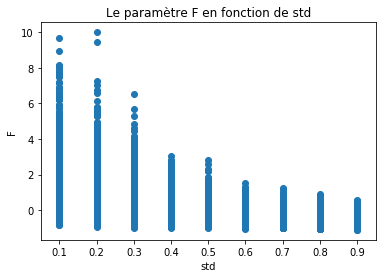

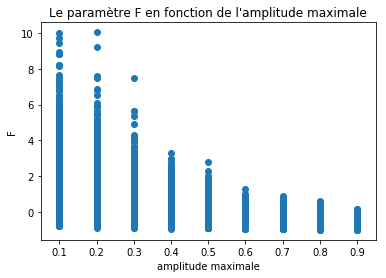

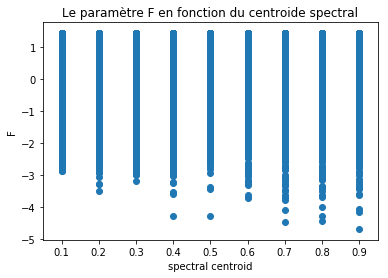

In [23]:
plt.scatter(Y_data[:, 0], X_data[:, 1])
plt.title('Le paramètre F en fonction de std')
plt.xlabel('std')
plt.ylabel('F')
plt.show()

plt.scatter(Y_data[:, 0], X_data[:, 3])
plt.title("Le paramètre F en fonction de l'amplitude maximale")
plt.xlabel('amplitude maximale')
plt.ylabel('F')
plt.show()

plt.scatter(Y_data[:, 0], X_data[:, 4])
plt.title("Le paramètre F en fonction du centroide spectral")
plt.xlabel('spectral centroid')
plt.ylabel('F')
plt.show()

## 2. Apprendre `(F, k)` avec une regression linéaire
Pour trouver les poids des descripteurs

In [24]:
def train_regr_lin(X_train, Y_train, X_test, Y_test):
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)

    y_pred = regr.predict(X_test)
    print("MSE on test set:", mean_squared_error(y_pred, Y_test))
    
    return regr

In [25]:
_ = train_regr_lin(X_train, Y_train, X_test, Y_test)

MSE on test set: 0.0669548218282


-> L'erreur est assez variable selon le jeu de données et j'ai du mal à voir pourquoi

#### Prédiction de `F`

In [26]:
regr_f = train_regr_lin(X_train, Y_train[:, 0], X_test, Y_test[:, 0])

MSE on test set: 0.0367721448853


In [27]:
regr_f.coef_

array([ 0.00307583,  0.02519561, -0.01555879, -0.1798494 ,  0.09989009,
        0.13800494,  0.08744662, -0.04684511, -0.00131048])

In [ ]:
names_desc

In [32]:
def normalize_coef(coefs, seuil=0.005):
    coefs_treated = [abs(x) for x in coefs]
    coefs_treated = [x if x > seuil else 0 for x in coefs_treated]
    
    # Somme = 1
    coefs_treated /= np.sum(coefs_treated)

    # Mettre dans un dico pour faire joli
    coefs_dico = {}
    for i in range(len(coefs_treated)):
        coefs_dico[names_desc[i]] = coefs_treated[i]
    
    return coefs_dico, coefs_treated
    
coefs_dico, coefs_treated = normalize_coef(regr_f.coef_)
print(coefs_treated)
coefs_dico

[ 0.          0.0425034   0.02624669  0.30339451  0.16850823  0.23280556
  0.14751689  0.07902472  0.        ]


{'ampl_max': 0.30339450789997796,
 'autocor': 0.0,
 'fr_max': 0.026246688086771799,
 'mean': 0.0,
 'spectral asymetry': 0.079024718054818338,
 'spectral centroid': 0.1685082342366867,
 'spectral platitude': 0.1475168912969064,
 'spectral width': 0.23280556440021585,
 'std': 0.042503396024622844}

In [33]:
regr_f.intercept_  # Zero à l'origine

0.50314850067904349

#### Prédiction de `k`

In [34]:
_ = train_regr_lin(X_train, Y_train[:, 1], X_test, Y_test[:, 1])

MSE on test set: 0.097137498771


#### Prediction de `F` avec normalisation

In [35]:
from sklearn import preprocessing

# Normalize data
scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = preprocessing.scale(X_data)

X_train_sc, X_test_sc, Y_train_sc, Y_test_sc = separate_test_train(
    X_scaled, Y_data, pct_train=0.8)

In [36]:
regr_f_sc = train_regr_lin(X_train_sc, Y_train_sc[:, 0], X_test_sc, Y_test_sc[:, 0])

MSE on test set: 0.0367721448853


In [37]:
coefs_dico_sc, coefs_treated_sc = normalize_coef(regr_f_sc.coef_)
print(coefs_treated_sc)
coefs_dico_sc

[ 0.          0.0425034   0.02624669  0.30339451  0.16850823  0.23280556
  0.14751689  0.07902472  0.        ]


{'ampl_max': 0.30339450789997685,
 'autocor': 0.0,
 'fr_max': 0.026246688086773107,
 'mean': 0.0,
 'spectral asymetry': 0.079024718054818463,
 'spectral centroid': 0.16850823423668651,
 'spectral platitude': 0.14751689129690651,
 'spectral width': 0.23280556440021599,
 'std': 0.042503396024622636}

Les coef changent complètement mais le MSE est identique -> les

## 3. ACP

In [42]:
from sklearn.decomposition import PCA

In [43]:
from sklearn import preprocessing

# Normalize data

scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = preprocessing.scale(X_data)

#### Projection en 2D

In [44]:
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data=principal_comp, columns=['principal component 1', 'principal component 2'])
principal_df['target'] = Y_data[:, 0]

In [45]:
x = pca.explained_variance_ratio_
print(x)
print("La premiere composante principale explique {}% de la variance des données".format(round(x[0] * 100, 2)))

[ 0.26793894  0.23945336]
La premiere composante principale explique 26.79% de la variance des données


In [46]:
pca.components_

array([[  8.61553724e-03,   1.10803878e-01,  -8.25774517e-02,
          7.66152478e-02,   4.88491148e-01,  -6.14936850e-01,
          5.98444436e-01,   4.61096272e-04,  -7.24264990e-03],
       [ -1.53466284e-02,   6.33808423e-01,  -1.69428694e-02,
          6.28684731e-01,  -3.03422784e-01,   4.44251311e-02,
          9.37283210e-02,  -3.15599263e-01,   9.64057386e-03]])

-> Coordonnées des premières et deuxiemes composantes principales dans l'espace des descripteurs

ACP pour faire de la réduction de dimension: projetter sur un certains nb de composantes principales (nb < au nb de coord)

**Problème de l'ACP:** la moyenne, variance, etc... sont les variables qui permettent le mieux d'"étaler" les points alors qu'elles ne sont pas pertinentes ici, car le but est de classifier en fonction de F et k

-> Utile en non supervisé lorque l'on a vraiment aucune idée de ce que l'on cherche

## 4. SVM

In [ ]:
from sklearn.svm import SVR, LinearSVR

In [ ]:
clf = SVR()

clf.fit(X_train, Y_train[:, 0])

Y_pred = clf.predict(X_test)
print("MSE on F:", mean_squared_error(Y_pred, Y_test[:, 0]))

In [ ]:
# Linear kernel to get the coefs (like Linear Regression)

clf = LinearSVR()

clf.fit(X_train, Y_train[:, 0])

Y_pred = clf.predict(X_test)
print("MSE on F:", mean_squared_error(Y_pred, Y_test[:, 0]))

In [ ]:
clf.coef_

## 5. Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train[:, 0])

In [ ]:
y_pred = tree.predict(X_test)
print("MSE on F for regressor tree:", mean_squared_error(y_pred, Y_test[:, 0]))

In [ ]:
tree.feature_importances_

## XGBoost, autre, ...